In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
import scipy.io
from pyDOE import lhs
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
device=torch.device("cpu")

torch.manual_seed(1234)
np.random.seed(1234)

## Schrodinger
$$ih_t+0.5h_{xx}+|h|^2h=0$$
$$x\in[-5,5],\quad t\in[0,\pi/2]$$
$$h(0,x)=2sech(x)$$
$$h(t,-5)=h(t,5)$$
$$h_x(t,-5)=h_x(t,5)$$

In [3]:
noise=0.0
lb=np.array([-5.0, 0.0])
ub=np.array([5.0, np.pi/2])

In [4]:
# noise=0.0
xl=-5
xu=5
tl=0
tu=np.pi/2

In [5]:
N0=50
N_b=50
N_f=2000
# layers=[2,100,100,100,100,2]
layers=[2,100,100,100,100,2]

data=scipy.io.loadmat('./data/NLS.mat')

In [73]:
t=data['tt'].flatten()[:,None] # t: 0 ~ pi/2
x=data['x'].flatten()[:,None] # x: -5~5
Exact=data['uu'] # 정답

In [102]:
x.shape

(257, 1)

In [93]:
x=np.append(x,np.array([-x[0]]),axis=0)

In [94]:
Exact.shape

(256, 201)

In [103]:
Exact=np.append(Exact,np.array([Exact[0,:]]),axis=0)

In [104]:
Exact_u=np.real(Exact) # value의 실수 
Exact_v=np.imag(Exact) # value의 허수

In [105]:
Exact_h=np.sqrt(Exact_u**2+Exact_v**2)

In [106]:
print(Exact[0,1])
print(Exact_u[0,1], Exact_u[0,1]**2)
print(Exact_v[0,1], Exact_v[0,1]**2)
print(np.sqrt(Exact_u[0,1]**2+Exact_v[0,1]**2))
print(Exact_h[0,1])

(0.028270116393807054+0.0014690327316345744j)
0.028270116393807054 0.0007991994809193984
0.0014690327316345744 2.1580571666137397e-06
0.02830825918501546
0.02830825918501546


In [107]:
X,T=np.meshgrid(x,t) # 크기에 맞게 grid 형성
print(X.shape,T.shape)

(201, 257) (201, 257)


In [108]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_star.shape

(51657, 2)

In [109]:
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

In [110]:
u_star.shape

(51657, 1)

In [111]:
## N0만큼 inital value를 뽑음
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

In [112]:
x.shape

(257, 1)

In [113]:
Exact_u.shape

(257, 201)

In [114]:
print(x0.shape, u0.shape, v0.shape)

(50, 1) (50, 1) (50, 1)


In [115]:
X_ic=torch.zeros((N0,2),dtype=torch.float64,device=device)
X_ic[:,0:1]=torch.tensor(x0)
X_ic[:,1]=tl

H_ic=torch.zeros((N0,2),dtype=torch.float64,device=device)
H_ic[:,0:1]=torch.tensor(u0)
H_ic[:,1:2]=torch.tensor(v0)

In [118]:
X_ic.shape, H_ic.shape

(torch.Size([50, 2]), torch.Size([50, 2]))

In [123]:
## Nb만큼 boundary value를 뽑음
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
# u_lb = Exact_u[0:1,idx_t]
# v_lb = Exact_v[0:1,idx_t]

In [130]:
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

In [131]:
# H_ubc=torch.zeros((N_b,2),dtype=torch.float64,device=device)

# H_ubc[:,0]=torch.tensor(np.reshape(u_lb,-1))
# H_ubc[:,1]=torch.tensor(np.reshape(v_lb,-1))

# H_lbc=torch.zeros((N_b,2),dtype=torch.float64,device=device)
# H_lbc[:,0]=torch.tensor(np.reshape(u_lb,-1))
# H_lbc[:,1]=torch.tensor(np.reshape(v_lb,-1))

In [132]:
X_f = lb + (ub-lb)*lhs(2, N_f)

In [133]:
X_f.shape

(2000, 2)

In [141]:
X_f

array([[2.18583467, 0.39672505],
       [0.95465667, 0.80682603],
       [1.44865721, 0.26620616],
       ...,
       [0.40560812, 1.07052783],
       [4.77158591, 1.13830104],
       [4.26094079, 0.01677851]])

In [135]:
# X_colloc=torch.zeros((N_f,2),dtype=torch.float64,device=device)
# X_colloc[:,0]=torch.rand(N_f)*(xu-xl)+xl
# X_colloc[:,1]=torch.rand(N_f)*(tu-tl)+tl
# X_colloc.requires_grad_()

In [136]:
# X_colloc.shape

In [137]:
X_test=torch.tensor(X_star)
h_test=torch.tensor(h_star)

In [155]:
X_test.shape

torch.Size([51657, 2])

In [138]:
def schrodinger(net, xt):
    h=net.forward(xt)
    hu, hv=h[:,0:1],h[:,1:2]

    Dhu=grad(hu.sum(),xt,create_graph=True)[0]
    Dhv=grad(hv.sum(),xt,create_graph=True)[0]

    hu_x, hu_t=Dhu[:,0:1], Dhu[:,1:2]
    hv_x, hv_t=Dhv[:,0:1], Dhv[:,1:2]
    
    hu_xx=grad(hu_x.sum(), xt, create_graph=True)[0][:,0:1]
    hv_xx=grad(hv_x.sum(), xt, create_graph=True)[0][:,0:1]
    loss_fu=hu_t+0.5*hv_xx+(hu**2+hv**2)*hv
    loss_fv=hv_t-0.5*hu_xx-(hu**2+hv**2)*hu
    
    
    loss_fu=torch.mean(torch.square(loss_fu))
    loss_fv=torch.mean(torch.square(loss_fv))
    
    return loss_fu+loss_fv

In [139]:
def boundary(net, x_ubc,x_lbc):
    H_ubc=net.forward(x_ubc)
    H_lbc=net.forward(x_lbc)
    
    Hu_ubc,Hv_ubc=H_ubc[:,0:1],H_ubc[:,1:2]
    Hu_lbc,Hv_lbc=H_lbc[:,0:1],H_lbc[:,1:2]
    
    DHu_ubc=grad(Hu_ubc.sum(),x_ubc,create_graph=True)[0]
    DHv_ubc=grad(Hv_ubc.sum(),x_ubc,create_graph=True)[0]

    DHu_lbc=grad(Hu_lbc.sum(),x_lbc,create_graph=True)[0]
    DHv_lbc=grad(Hv_lbc.sum(),x_lbc,create_graph=True)[0]
    
    Hu_ubc_x=DHu_ubc[:,0:1]
    Hv_ubc_x=DHv_ubc[:,0:1]

    Hu_lbc_x=DHu_lbc[:,0:1]
    Hv_lbc_x=DHv_lbc[:,0:1]
    
    loss_u=torch.mean(torch.square(Hu_ubc-Hu_lbc))
    loss_v=torch.mean(torch.square(Hv_ubc-Hv_lbc))


    loss_ux=torch.mean(torch.square(Hu_ubc_x-Hu_lbc_x))
    loss_vx=torch.mean(torch.square(Hv_ubc_x-Hv_lbc_x))
    
    return loss_u+loss_v+loss_ux+loss_vx

In [140]:
def calculate_relative_err(net):
    u_pred=net.predict(X_test)
    h_pred=torch.sqrt(u_pred[:,0]**2+u_pred[:,1]**2).view(*(h_test.shape))
    err=torch.abs(h_pred-h_test)
    err=torch.linalg.norm(err)/torch.linalg.norm(h_test)
    return err.item()

In [149]:
class PINN(nn.Module):
    
    def __init__(self, X_lb, X_ub, X0, X_f, governing_eqn=None, layers=[100,100,100,100]):
        super(PINN, self).__init__()
        
        # Input variable
        self.X0=torch.tensor(X0,dtype=torch.float64,device=device,requires_grad=True)
        
        self.X_lb=torch.tensor(X_lb,dtype=torch.float64,device=device,requires_grad=True)
        self.X_ub=torch.tensor(X_ub,dtype=torch.float64,device=device,requires_grad=True)
        self.X_f=torch.tensor(X_f,dtype=torch.float64,device=device,requires_grad=True)
        
        
#         X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
#         X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
#         X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
#         self.lb = lb
#         self.ub = ub
               
#         self.x0 = X0[:,0:1]
#         self.t0 = X0[:,1:2]

#         self.x_lb = X_lb[:,0:1]
#         self.t_lb = X_lb[:,1:2]

#         self.x_ub = X_ub[:,0:1]
#         self.t_ub = X_ub[:,1:2]
        
#         self.x_f = X_f[:,0:1]
#         self.t_f = X_f[:,1:2]
        
#         self.u0 = u0
#         self.v0 = v0
        
        # Basic settings
        self.governing_eqn=governing_eqn
        self.device=device
        

        # Input and output dimension
        input_dim=2
        output_dim=2
                
        # set neural network structure
        self.n_hidden=len(layers)
        self.fcs=nn.ModuleList()
        
        for layer in range(self.n_hidden+1):
            self.fcs.append(nn.Sequential(*[nn.Linear(in_features = input_dim if layer == 0 else layers[layer -1],
                                                  out_features = output_dim if layer == self.n_hidden else layers[layer],
                                                  bias = True)]))
            nn.init.xavier_normal_(self.fcs[layer][0].weight)
            nn.init.zeros_(self.fcs[layer][0].bias)
            
    
    def forward(self,x):
               
        for i in range(self.n_hidden):
            x=self.fcs[i](x)
            x=torch.tanh(x)
        
        x=self.fcs[self.n_hidden](x)
        
        return x
    
    def loss_func(self):
        
        # fn error
        loss_colloc=self.governing_eqn(self, self.X_f)
           
        # initial condition error
        H_ic_pred=self.forward(self.X0)
        loss_ic=torch.mean(torch.square(H_ic_pred-H_ic))
        
        # boudary codition error
        loss_bc=boundary(self,self.X_ub,self.X_lb)
    
        return loss_colloc+loss_ic+loss_bc
        
    def train(self,num_iter=10000):
        self.loss_history=[]
        self.l2error_history=[]
        
        self.history_interval=100
        
        optimizer=torch.optim.LBFGS(self.parameters(),lr=1, max_iter=1, history_size=10, line_search_fn='strong_wolfe' )
#         optimizer=torch.optim.Adam(self.parameters())
        
        start=time.time()
        
        for count in range(num_iter):
            
            def closure():
                optimizer.zero_grad()
                loss=self.loss_func()
                loss.backward()
                return loss
            
            optimizer.step(closure)
            loss=closure()
            
            if count % self.history_interval==0:
                err=calculate_relative_err(net)
                self.loss_history.append(loss.detach().item())
                self.l2error_history.append(err)
            
            if count % 1000==0:
                 print(f"Iter: {count}, Loss: {self.loss_history[int(count/self.history_interval)]}")
            
            if count>self.history_interval:
                if self.loss_history[-1]==self.loss_history[-2]:
                    print("Total Iteration:",count)
                    break
                    
        end=time.time()
        print(f"Traning tiem:{end-start} seconds")
        
    def predict(self,X_new):
        pred_outs=self.forward(X_new)
        return pred_outs

In [197]:
net=PINN(governing_eqn=schrodinger,
        layers=[100,100,100,100],
        X0=X0,X_f=X_f,X_ub=X_ub,X_lb=X_lb).to(device).double()

In [189]:
# net=PINN(governing_eqn=schrodinger,
#         layers=[100,100,100,100],
#         X0=X0,X_f=X,X_ub=X_ub,X_lb=X_lb).to(device).double()

In [152]:
# # Make a PINN network
# net = PINN(governing_eqn=schrodinger,
#             layers= [100,100,100,100]
#             ).to(device).double()

In [153]:
print(net)

PINN(
  (fcs): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)


In [211]:
# Trint PINN
net.train(num_iter=50000)

Iter: 0, Loss: 0.06855938019755045
Iter: 1000, Loss: 0.019792378563509926
Iter: 2000, Loss: 0.007916289730836574
Iter: 3000, Loss: 0.002810310433518898
Iter: 4000, Loss: 0.0011065998932617074
Iter: 5000, Loss: 0.00046455229561868423
Iter: 6000, Loss: 0.00025463487236039155
Iter: 7000, Loss: 0.00014027734953650517
Iter: 8000, Loss: 9.031301140796617e-05
Iter: 9000, Loss: 5.7936601418429634e-05
Iter: 10000, Loss: 4.3225718021451026e-05
Iter: 11000, Loss: 3.35432260440127e-05
Total Iteration: 11800
Traning tiem:9191.516466140747 seconds


In [212]:
u_pred=net.predict(X_test)
# h_pred=h_test
h_pred=torch.sqrt(u_pred[:,0]**2+u_pred[:,1]**2).view(*(h_test.shape))
err=torch.abs(h_pred-h_test)
err=torch.linalg.norm(err)/torch.linalg.norm(h_test)
print("Relative L2-error norm: {}".format(err))

Relative L2-error norm: 0.006313147991536304


In [213]:
H_pred = griddata(X_star, h_pred.detach().numpy().flatten(), (X, T), method='cubic')

In [214]:
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

Text(0.5, 1.0, '$|h(t,x)|$')

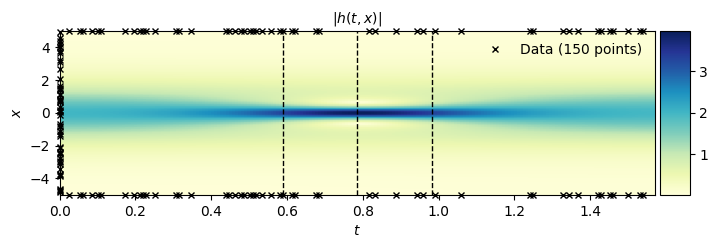

In [215]:
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
fig = plt.figure(figsize=(9,6))
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

Text(0.5, 1.0, '$t = 0.98$')

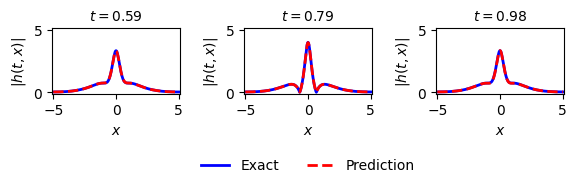

In [216]:
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)